In [1]:
from google.colab import drive
drive.mount('/content/drive')

root_dir = '/content/drive/My Drive/EC523/EC523_GTP'

Mounted at /content/drive


In [2]:
import os
import glob
import csv
import pandas as pd
import yaml
import numpy as np
import matplotlib.pyplot as plt
import pickle
import torch
import torch.nn as nn
from torch.utils.data import random_split
import sys
sys.path.append(root_dir)

os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv

from GraphTransformer.dataset import GraphDataset
from GraphTransformer.model import GraphTransformer

2.5.1+cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 98.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 46.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


## Write a set of filepaths to a .csv file

In [ ]:
# create the list of files to write
paths = glob.glob(os.path.join(root_dir, 'image_graphs/test_graphs/*.pth'))
print(len(paths))

In [ ]:
# set the path to the output csv and write each file as a line
csv_path = os.path.join(root_dir, 'test_graph_paths.csv')

with open(csv_path, mode='a', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)

    for relative_path in paths:
        csv_writer.writerow([relative_path])

In [ ]:
# read the number of entries in the file to check it
csv_path = os.path.join(root_dir, 'graph_paths.csv')
csv_file = pd.read_csv(csv_path)
print(len(csv_file))

## Test the classifier

In [3]:
# load the yaml file
config = yaml.load(open(os.path.join(root_dir, 'config.yaml'), 'r'), Loader=yaml.FullLoader)
eval_params = config['transformer_evaluation']
model_params = config['model']
graph_transformer_params = config['graph_transformer']

In [4]:
# get path to folder with classifier models and put them in a list
model_list = glob.glob(os.path.join(root_dir, eval_params['model_dir'], '*.pth'))
print(len(model_list))

251


In [5]:
# make a Dataset and DataLoader with the test graphs
test_dataset = GraphDataset(csv_file = os.path.join(root_dir, eval_params['test_graphs_csv']))
test_loader = DataLoader(test_dataset, batch_size=eval_params['batch_size'], shuffle=False)

In [6]:
# instantiate the model and loss for evaluation
model = GraphTransformer(data_features=model_params['out_dim'],
                         embed_dim=graph_transformer_params['embed_dim'],
                         num_heads=graph_transformer_params['num_heads'],
                         mlp_dim=graph_transformer_params['mlp_dim'],
                         num_layers=graph_transformer_params['num_layers'],
                         num_classes=graph_transformer_params['num_classes'])


criterion = nn.CrossEntropyLoss()

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [7]:
# test on each model
test_losses = []

with torch.no_grad():

    for checkpoint in model_list:

        test_loss = []

        params = torch.load(checkpoint)
        model.load_state_dict(params['model_state_dict'])
        model = model.double()
        model.eval()
        model = model.to(device)

        for graph_batch, encoding_batch in test_loader:

            graph_batch = graph_batch.to(device)
            encoding_batch = encoding_batch.to(device)

            out = model(x=graph_batch.x,
                    edge_idx=graph_batch.edge_index,
                    batch=graph_batch.batch,
                    pos_enc=encoding_batch.x)

            loss = criterion(out, graph_batch.y)

            test_loss.append(loss.item())

        test_losses.append(np.mean(np.array(test_loss)))

<ipython-input-7-2672ee1a28d3>:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  params = torch.load(checkpoint)
/content/drive/My Drive/EC523/EC523_GTP/GraphTransformer/dat

In [8]:
# test on the best performing model

y_true = []
y_pred = []

model = GraphTransformer(data_features=model_params['out_dim'],
                         embed_dim=graph_transformer_params['embed_dim'],
                         num_heads=graph_transformer_params['num_heads'],
                         mlp_dim=graph_transformer_params['mlp_dim'],
                         num_layers=graph_transformer_params['num_layers'],
                         num_classes=graph_transformer_params['num_classes'])

with torch.no_grad():

    params = torch.load(os.path.join(root_dir, eval_params['best_model']))
    model.load_state_dict(params['model_state_dict'])
    model = model.double()
    model.eval()
    model = model.to(device)

    for graph_batch, encoding_batch in test_loader:

        graph_batch = graph_batch.to(device)
        encoding_batch = encoding_batch.to(device)

        out = model(x=graph_batch.x,
                edge_idx=graph_batch.edge_index,
                batch=graph_batch.batch,
                pos_enc=encoding_batch.x)

        y_true.extend(graph_batch.y.cpu().tolist())
        y_pred.extend(out.argmax(dim=1).cpu().tolist())

<ipython-input-8-23770247ad49>:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  params = torch.load(os.path.join(root_dir, eval_params['best_model']))


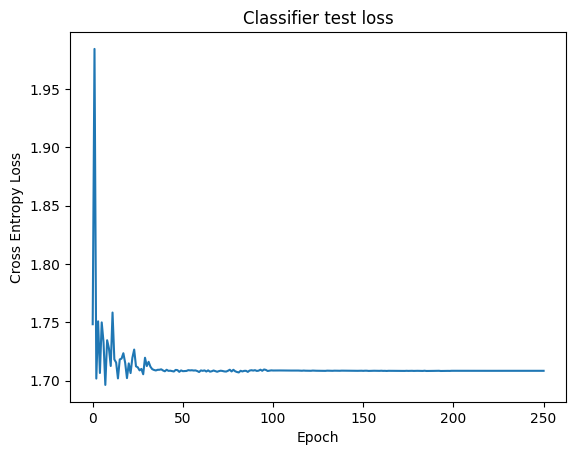

In [9]:
# plot a test loss curve for each model checkpoint
plt.plot(test_losses)

plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.title('Classifier test loss')

plt.show()

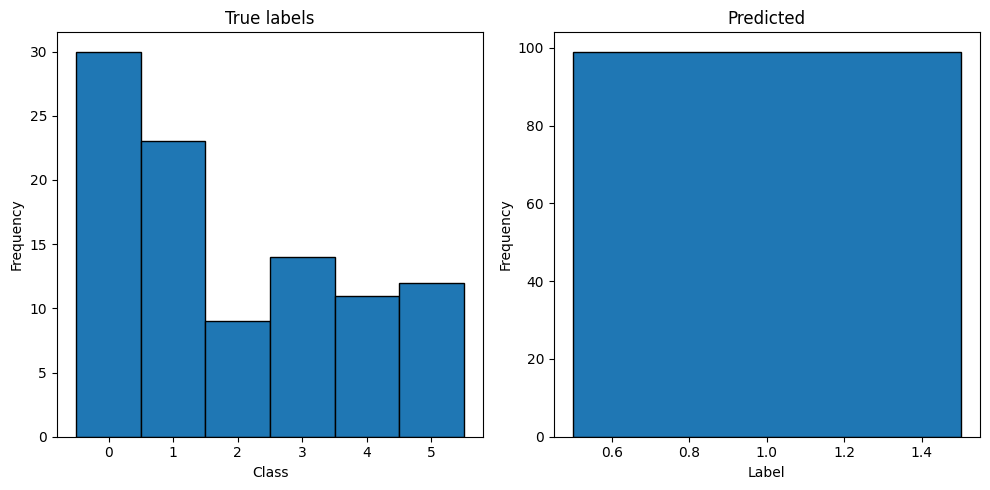

In [10]:
# create histograms with true, predicted labels for best performing models
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# true labels
axes[0].hist(y_true, bins=range(min(y_true), max(y_true) + 2), edgecolor='black', align='left')
axes[0].set_title('True Labels')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Frequency')

# predicted labels
axes[1].hist(y_pred, bins=range(min(y_pred), max(y_pred) + 2), edgecolor='black', align='left')
axes[1].set_title('Predicted Labels')
axes[1].set_xlabel('Label')
axes[1].set_ylabel('Frequency')


plt.tight_layout()
plt.show()

## Plot training and validation loss data

In [19]:
# load the loss data for the ResNet
resnet_loss = glob.glob(os.path.join(root_dir, 'results/feature_extractor/evaluation/*.pkl'))
print(len(resnet_loss))

epoch = []
train_loss = []
val_loss = []
for loss_dict in resnet_loss:

    with open(loss_dict, 'rb') as file:
        loss_data = pickle.load(file)

    epoch.append(loss_data['epoch'])
    train_loss.append(loss_data['train_loss'])
    val_loss.append(loss_data['val_loss'])



30


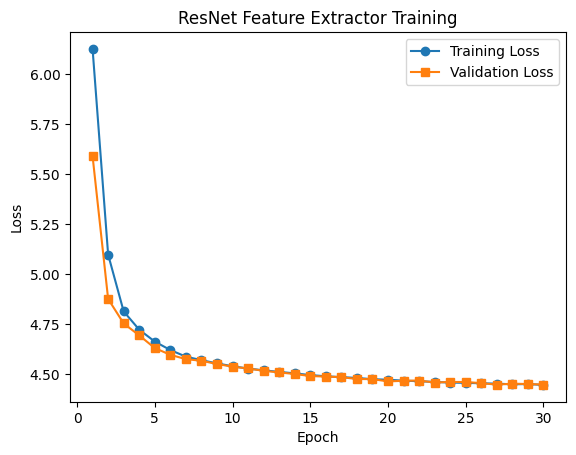

In [20]:
# plot training and validation loss for the feature extractor

plt.plot(epoch, train_loss, marker='o', label='Training Loss')
plt.plot(epoch, val_loss, marker='s', label='Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('ResNet Feature Extractor Training')
plt.legend()

plt.show()

In [21]:
# load the loss data for the classifier
resnet_loss = glob.glob(os.path.join(root_dir, 'results/graph_transformer/evaluation/*.pkl'))
print(len(resnet_loss))

epoch = []
train_loss = []
val_loss = []
for loss_dict in resnet_loss:

    with open(loss_dict, 'rb') as file:
        loss_data = pickle.load(file)

    epoch.append(loss_data['epoch'])
    train_loss.append(loss_data['train_loss'])
    val_loss.append(loss_data['val_loss'])

250


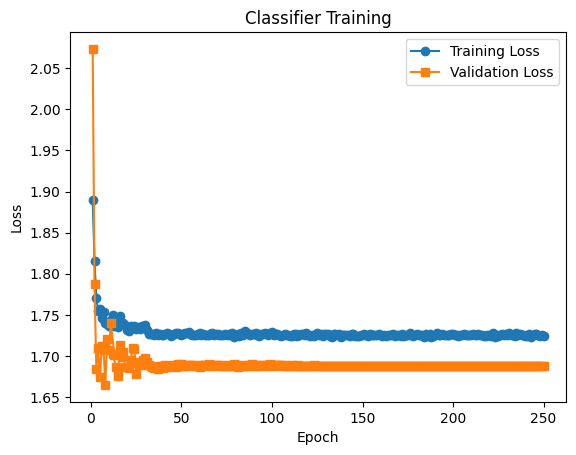

In [22]:
# plot training and validation loss for the graph transformer

plt.plot(epoch, train_loss, marker='o', label='Training Loss')
plt.plot(epoch, val_loss, marker='s', label='Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Classifier Training')
plt.legend()

plt.show()